In [1]:
import sys
sys.path.append("..")

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

_display_plot_rcParams = {
    'figure.figsize' : [10,7],
    'figure.dpi' : 100,
    'xtick.top' : True,
    'xtick.direction' : 'in',
    'xtick.minor.visible' : True,
    'ytick.right' : True,
    'ytick.direction' : 'in',
    'ytick.minor.visible' : True,
    'font.size' : 12,
    'mathtext.default' : 'regular',
    'font.family' : 'DejaVu Serif',
    }
plt.rcParams.update(_display_plot_rcParams)

In [2]:
import torch.nn as nn
import torch
import random
import numpy as np

In [54]:
import shutil
import os

# base = os.path.expanduser("~/data/atlas/qcd_llp_datasets/")
# qcd = base+"QCD_multijet_events_200k.root"
# llp = [base+"500GeV_n3_events_100k_1mm_pileup.root", base+'100GeV_n3_events_100k_1mm_pileup.root']

# # copy all files to lscratch!
jobid,=!echo $SLURM_JOB_ID
# for root in [qcd]+llp:
#     print(f"Copying {root} to /lscratch/youngsam/slurm_job_id_{jobid}/"+root.split("/")[-1])
    

root = "/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/Nc3Nf3_events_100k_pileup.root"
shutil.copy(root, f"/lscratch/youngsam/slurm_job_id_{jobid}/"+root.split("/")[-1])
root = "/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/Nc3Nf3_events_100k.root"
shutil.copy(root, f"/lscratch/youngsam/slurm_job_id_{jobid}/"+root.split("/")[-1])

'/lscratch/youngsam/slurm_job_id_40012921/Nc3Nf3_events_100k.root'

In [4]:
from ad.models.networks.dnn import DNNClassifier
import torch
from torch.utils.data import random_split
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def test_classifier(classifier, dset):
    classifier.eval()
    accuracy = 0.0
    total = 0.0
    with torch.no_grad():
        for batch in dset:
            inputs, masks, labels = batch
            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            output = classifier(batch)
            predicted = torch.sigmoid(output.data) > 0.5

            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    return accuracy / total * 100


def train_classifier(
    dataset,
    batch_size=2048,
    epochs=100,
    notify_every=10,
    lr=0.001,
    tqdm=tqdm,
    reduce_lr=False,
):
    if tqdm is False:
        tqdm = lambda x, **kwargs: x

    hparams = dict(
        input_features=5,
        hidden_layers=3,
        hidden_features=32,
        output_features=1,
        batch_norm=True,
        layer_norm=False,
        hidden_activation="ReLU",
        output_activation=None,
        final_reduction="mean",
        input_dropout=0.0,
        hidden_dropout=0.0,
    )

    classifier = DNNClassifier(hparams).to(device)

    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)

    if reduce_lr:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, "min", patience=10, verbose=True
        )

    val_split = 0.1
    train, val = random_split(dataset, [1 - val_split, val_split])

    kwargs = dict(shuffle=True, pin_memory=True, batch_size=batch_size, drop_last=True)
    dataloader = {
        "train": DataLoader(train, **kwargs, num_workers=6),
        "val": DataLoader(val, **kwargs, num_workers=2),
    }

    max_acc = 0.0
    accuracies = []
    losses = []
    for epoch in tqdm(range(epochs), total=epochs, desc="Training"):
        running_loss = []
        for i, batch in enumerate(dataloader["train"]):
            optimizer.zero_grad()
            inputs, masks, labels = batch
            inputs = inputs.to(device)
            masks = masks.to(device)
            labels = labels.to(device)

            output = classifier(batch)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += [loss.item()]
            losses.append(loss.item())

        if reduce_lr:
            scheduler.step(losses[-1])

        accuracy = test_classifier(classifier, dataloader["val"])
        accuracies.append(accuracy)
        if accuracy > max_acc:
            max_acc = accuracy
        if notify_every > 0 and (epoch + 1) % notify_every == 0:
            print(
                f"[{epoch+1:>{len(str(epoch))}}] max acc: {max_acc:.1f}%, test acc: {accuracy:.1f}%, loss: {np.mean(running_loss):.3f}"
            )
    return classifier, accuracies, losses, dataloader

In [1]:
# https://cernbox.cern.ch/files/link/public/MYQ9q9P59RwLvgw
base = "/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/pileup/"
qcd = base + "QCD_multijet_events_200k_pileup.h5"
llp = [
    base + "500GeV_n3_events_100k_1mm_pileup.h5",
    base + "100GeV_n3_events_100k_1mm_pileup.h5",
]

In [2]:
from ad.models.utils import H5DVDataset

signal = llp
background = qcd
dset = H5DVDataset(signal, background, read_in_memory=True, num_high_pt=80)

In [ ]:
clf, accuracies, losses, datasets = train_classifier(
    dset,
    lr=0.001,
    batch_size=1024,
    epochs=10,
    notify_every=1,
)

# torch.save(clf.state_dict(), "weights/dnn_80track_10epoch_normalizedPT_n3_1mm_pileup.pt")

In [6]:
# save classifier to disk
# torch.save(clf.state_dict(), "classifier.pt")

# load classifier from disk
clf = DNNClassifier(
    in_features=5,
    hidden_layers=3,
    hidden_features=32,
    out_features=2,
    permute_input=True,
    normalize_input=True,
    final_reduction="mean",
).to(device)
# clf.load_state_dict(torch.load("weights/dbb_1track_50epoch_normalizedPT.pt"))

In [58]:
def get_output(classifier, inputs, masks, labels):
    classifier.eval()
    with torch.no_grad():
        inputs = inputs.permute(0, 2, 1).to(device)
        masks = masks.permute(0, 2, 1)[:, [0], :].to(device)
        labels = labels.long().to(device)
        labels = F.one_hot(labels.ravel(), num_classes=2)

        output = classifier(inputs, masks)
        output = torch.sigmoid(output)
        return output

def plot_sic(y_true, y_scores, label='SIC curve'):
    # Sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_scores)[::-1]
    y_scores = y_scores[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # Get the distinct values
    distinct_value_indices = np.where(np.diff(y_scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # True Positive Rates, False Positive Rates
    tps = np.cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps

    # If no true positives, fix the TPRs and FPRs
    if tps.size == 0 or tps[-1] == 0:
        tpr = np.zeros_like(fps)
        fpr = np.zeros_like(fps)
    else:
        tpr = tps / tps[-1]
        fpr = fps / fps[-1]


    # get TPR/FPR at 50% cut

    # plt.scatter(tpr_at_50, tpr_at_50/np.sqrt(fpr_at_50), label=label)
    fig, ax = plt.subplots(figsize=(8,5))
    plt.plot(tpr, tpr/np.sqrt(fpr), lw=2, label=label)
    plt.xlabel("$\\varepsilon_S$", fontsize=20)
    plt.ylabel("$\\varepsilon_S/\\sqrt{\\varepsilon_B}", fontsize=20)
    plt.title("SIC curve")

/tmp/ipykernel_2069419/2103879532.py:38: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, tpr/np.sqrt(fpr), lw=2, label=label)


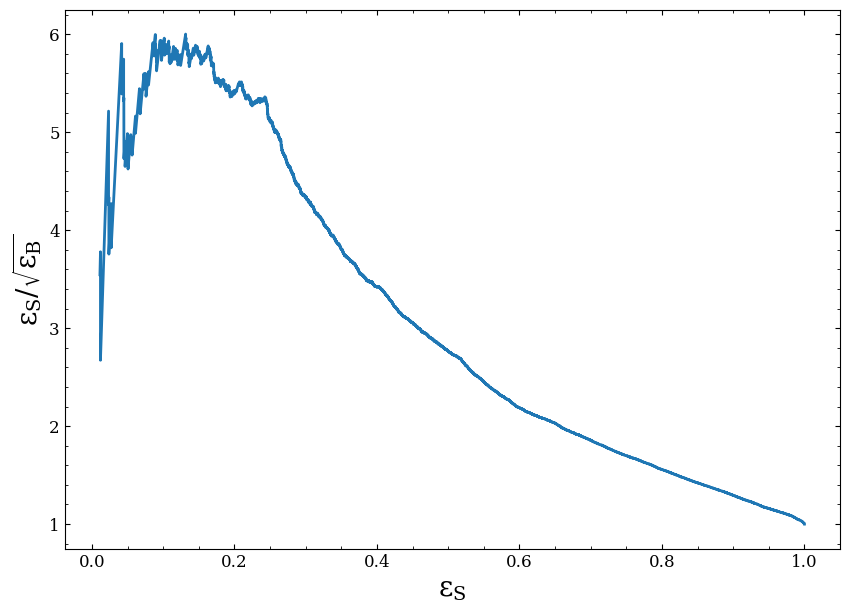

In [59]:
inputs = datasets['val'].dataset.dataset.inputs
masks = datasets['val'].dataset.dataset.masks
labels = datasets['val'].dataset.dataset.labels

output = get_output(clf, inputs, masks, labels)
y_pred = output[:, 1].cpu().numpy()
y_truth = labels.cpu().numpy().ravel()

plot_sic(y_truth, y_pred)

/tmp/ipykernel_2069419/2103879532.py:38: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, tpr/np.sqrt(fpr), lw=2, label=label)


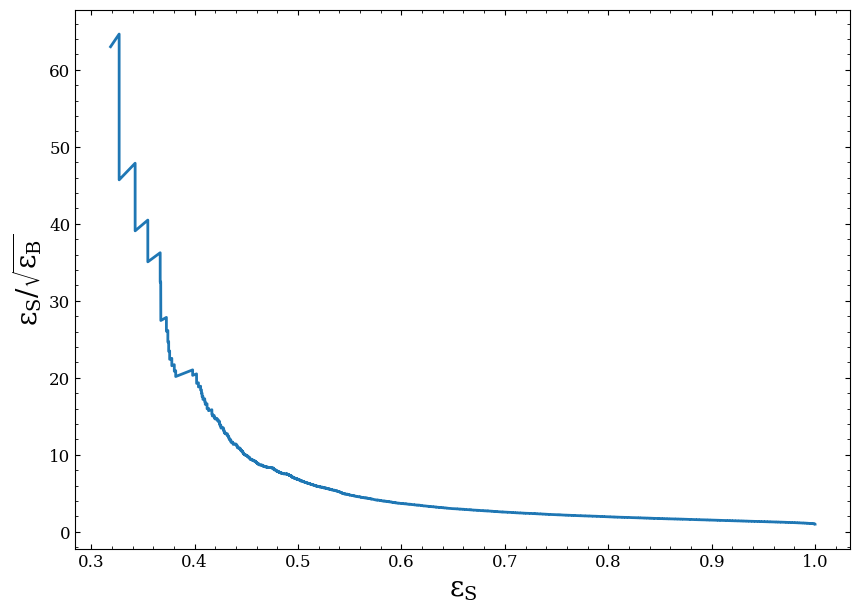

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(inputs, labels,
                                                    test_size=0.2)

# tracks are ordered by pt low to high, so we can
# just take the first feature (pt) of the last track
X_train = X_train[:,-1,[0]].numpy()
X_test = X_test[:,-1,[0]].numpy()
y_train = y_train.ravel().numpy()
y_test = y_test.ravel().numpy()

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:,1]

plot_sic(y_test, y_pred_proba, label='Logistic Regression')

/tmp/ipykernel_2106540/1954148296.py:30: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, tpr/np.sqrt(fpr), lw=2, label=label)


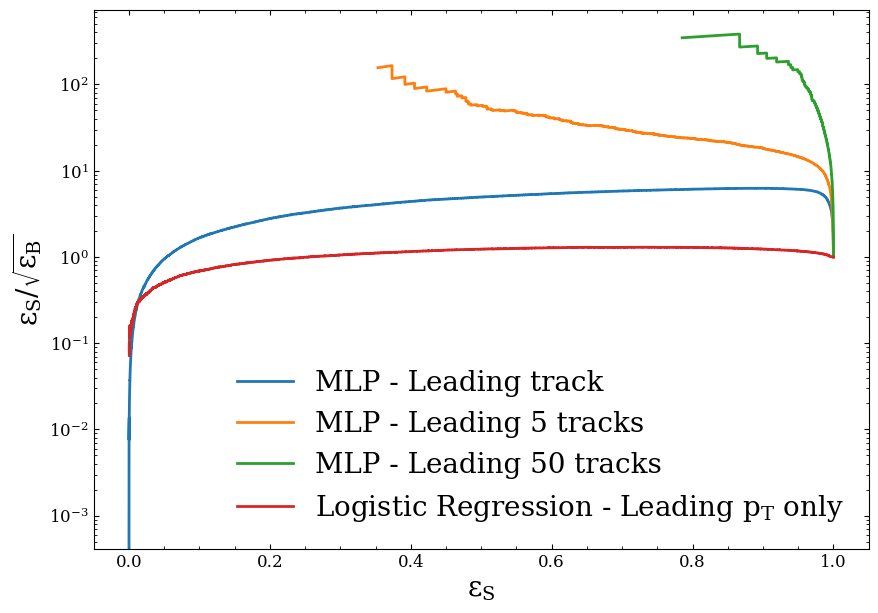

In [27]:
weights = ['dnn_1track_50epoch_normalizedPT.pt', 'dnn_5track_50epoch_normalizedPT.pt', 
           'dnn_50track_50epoch_normalizedPT.pt']
names = 'MLP - Leading track', 'MLP - Leading 5 tracks', 'MLP - Leading 50 tracks'


plt.figure()
for w, n in zip(weights, names):
    clf = DNNClassifier(
        in_features=5,
        hidden_layers=3,
        hidden_features=32,
        out_features=2,
        permute_input=True,
        normalize_input=True,
        final_reduction="mean",
    ).to(device)
    clf.load_state_dict(torch.load(f"weights/{w}", map_location=torch.device('cpu')))
    output = get_output(clf, inputs, masks, labels)
    y_pred = output[:, 1].cpu().numpy()
    y_truth = labels.cpu().numpy().ravel()

    plot_sic(y_truth, y_pred, label=n)
    
plot_sic(y_test, y_pred_proba, label='Logistic Regression - Leading $p_T$ only')
plt.legend(loc='lower right', frameon=False, fontsize=20)
plt.yscale('log')
plt.show()